In [14]:
import tensorflow as tf
from tensorflow import feature_column as fc

# Categorical base columns. (sparse vector)
real = {
    colname : fc.numeric_column(colname) \
          for colname in \
            ('age,education_num,capital_gain,capital_loss,hours_per_week').split(',')
}
# age_buckets = feature_column.bucketized_column(real['age'], boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
# real.update([age_buckets])
sparse = {
      'gender' : fc.categorical_column_with_vocabulary_list('gender', ["female", "male"]),
      'race' : fc.categorical_column_with_vocabulary_list('race', ["Amer-Indian-Eskimo", "Asian-Pac-Islander", "Black", "Other", "White"]),
      'education' : fc.categorical_column_with_hash_bucket('education', hash_bucket_size=100),
      'marital_status' : fc.categorical_column_with_hash_bucket('marital_status', hash_bucket_size=1000),
      'relationship' : fc.categorical_column_with_hash_bucket('relationship', hash_bucket_size=100),
      'workclass' : fc.categorical_column_with_hash_bucket('workclass', hash_bucket_size=100),
      'occupation' : fc.categorical_column_with_hash_bucket('occupation', hash_bucket_size=1000),
      'native_country'   : fc.categorical_column_with_hash_bucket('native_country', hash_bucket_size=1000)
}


inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=( ), dtype='string') \
          for colname in sparse.keys()
})


deep = tf.keras.layers.DenseFeatures(real.values())(inputs)
deep = tf.keras.layers.Dense(64, activation='relu')(deep)
deep = tf.keras.layers.Dense(16, activation='relu')(deep)
output = tf.keras.layers.Dense(1, activation='sigmoid')(deep)
model = tf.keras.Model(inputs, output)
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
#     deep = tf.keras.layers.DenseFeatures(dnn_feature_columns)(inputs)
#     for numnodes in dnn_hidden_units:
#         deep = tf.keras.layers.Dense(numnodes, activation='relu')(deep)        
#     wide = tf.keras.layers.DenseFeatures(linear_feature_columns)(inputs)
#     both = tf.keras.layers.concatenate([deep, wide])
#     output = tf.keras.layers.Dense(1, activation='sigmoid')(both)
#     model = tf.keras.Model(inputs, output)
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model
# model = wide_and_deep_classifier(inputs, sparse.values(), real.values(), [64, 16])

In [15]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
capital_gain (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
capital_loss (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
education (InputLayer)          [(None,)]            0                                            
_______________________________________________________________________________________

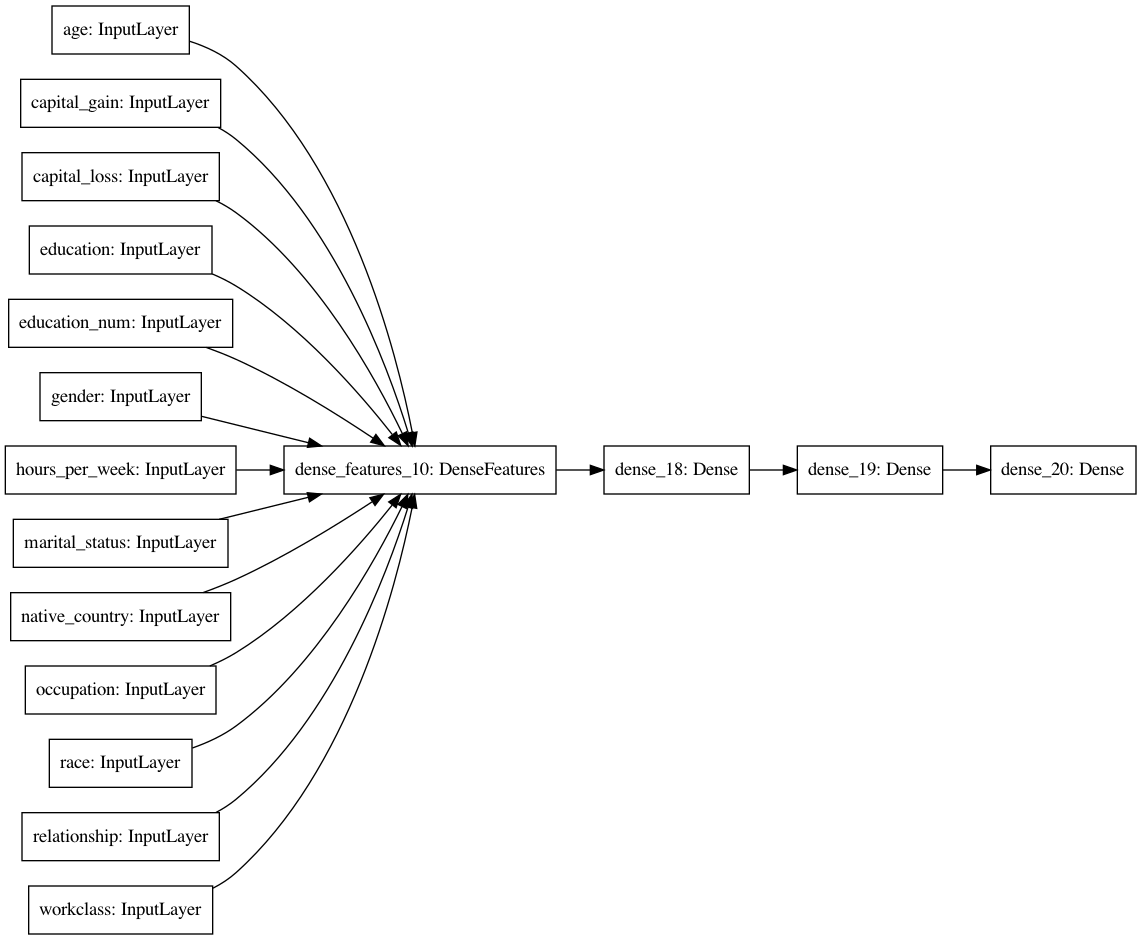

In [16]:
tf.keras.utils.plot_model(model, 'flights_deep_model.png', show_shapes=False, rankdir='LR')


In [17]:
REGION = 'us-central1'
DEVELOP_MODE = True
NBUCKETS = 5 # for embeddings
NUM_EXAMPLES = 1000*1000 # assume 1 million examples
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

TRAIN_DATA = "../dataset/ai-platform_census/adult.data"
TEST_DATA = "../dataset/ai-platform_census/adult.test"

In [18]:
import pandas as pd

# Define the column names for the data sets.
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
  "marital_status", "occupation", "relationship", "race", "gender",
  "capital_gain", "capital_loss", "hours_per_week", "native_country", "income_bracket"]
LABEL_COLUMN = 'label'
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
CONTINUOUS_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]



# Read the training and test data sets into Pandas dataframe.
df_train = pd.read_csv(TRAIN_DATA, names=COLUMNS, skipinitialspace=True)
df_test = pd.read_csv(TEST_DATA, names=COLUMNS, skipinitialspace=True, skiprows=1)

# label 설정
df_train[LABEL_COLUMN] = (df_train['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
df_test[LABEL_COLUMN] = (df_test['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)

# 판다스 데이터프레임으로부터 tf.data 데이터셋을 만들기 위한 함수
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

from sklearn.model_selection import train_test_split
batch_size = 100 # 예제를 위해 작은 배치 크기를 사용합니다.

train, val = train_test_split(df_train, test_size=0.3)
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(df_test, shuffle=False, batch_size=batch_size)
# print(batch_size)
# train_ds = train_ds.batch(100)
# val_ds = val_ds.batch(100)

In [19]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5


/Users/ohyeji/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['fnlwgt', 'income_bracket'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


228/228 [==============================] - 1s 4ms/step - loss: 3.8249 - accuracy: 0.7570 - val_loss: 0.5328 - val_accuracy: 0.7978
Epoch 2/5
228/228 [==============================] - 1s 3ms/step - loss: 0.7734 - accuracy: 0.7911 - val_loss: 0.5483 - val_accuracy: 0.8004
Epoch 3/5
228/228 [==============================] - 1s 3ms/step - loss: 1.0822 - accuracy: 0.7881 - val_loss: 0.7393 - val_accuracy: 0.7998
Epoch 4/5
228/228 [==============================] - 1s 3ms/step - loss: 0.7493 - accuracy: 0.7932 - val_loss: 0.7918 - val_accuracy: 0.7755
Epoch 5/5
228/228 [==============================] - 1s 3ms/step - loss: 0.6928 - accuracy: 0.7942 - val_loss: 1.1076 - val_accuracy: 0.7672


In [20]:
loss, accuracy = model.evaluate(test_ds)

163/163 [==============================] - 0s 2ms/step - loss: 1.0836 - accuracy: 0.7722
